In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

In [69]:
# load data 
df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
#df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
#df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)

#if(target == 'OU_LINE'): # Regression
#df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
#df['OU_LINE'] = df['ou_line']
#df['FINAL_OU'] = df['score1'] + df['score2']
#task = 'regression'
#target = 'FINAL_OU'

df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
df['SPREAD'] = df['spread']
df['FINAL_SPREAD'] = df['score1'] - df['score2']
task = 'regression'
target = 'FINAL_SPREAD'

# shift target column 
#target = 'SPREAD_RESULT'    # column name to predict

df = df[df['SPREAD_RESULT'] != 2]

Index(['Unnamed: 0', 'date', 'season', 'neutral', 'playoff', 'team1', 'team2',
       'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post',
       'elo2_post', 'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'year', 'spread', 'spread_result',
       'ou_line', 'ou_result', 'home_pass_cmp', 'home_pass_att',
       'home_pass_yds', 'home_pass_td', 'home_pass_int', 'home_pass_sacked',
       'home_pass_sacked_yds', 'home_pass_yds_per_att',
       'home_pass_net_yds_per_att', 'home_pass_cmp_perc', 'home_pass_rating',
       'home_rush_att', 'home_rush_yds', 'home_rush_yds_per_att',
       'home_rush_td', 'home_fgm', 'home_fga', 'home_xpm', 'home_xpa',
       'home_punt', 'home_punt_yds', 'home_third_down_success',


In [79]:
game_data_columns = []
for c in df.columns:
    if("home" in c or "away" in c or 'elo' in c):
        if('td' not in c and 'xp' not in c and 'fg' not in c and 'poss' not in c and 'down' not in c and target not in c and 'post' not in c):
        #if('poss' not in c and 'down' not in c and target not in c and 'post' not in c):
            game_data_columns.append(c)

#print(game_data_columns)
#game_data_columns.append(target)
benchmark_data = df[game_data_columns]
#benchmark_data['home_time_of_poss'] = benchmark_data['home_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))
#benchmark_data['away_time_of_poss'] = benchmark_data['away_time_of_poss'].apply(lambda x: 60*float(x[:2]) + float(x[3:]))

In [81]:
#print(benchmark_data.corr()['FINAL_SPREAD'].abs().sort_values())

/home/mlai/anaconda3/envs/nflbetting/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mlai/anaconda3/envs/nflbetting/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


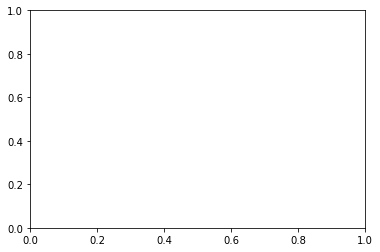

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(benchmark_data)

In [98]:
from matplotlib.lines import Line2D

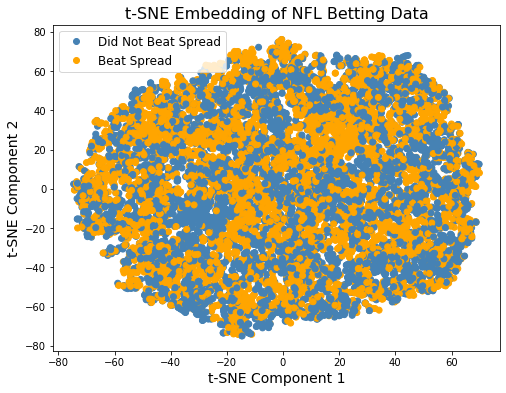

In [105]:
fig, ax = plt.subplots(figsize=(8,6))
colors = np.array(['steelblue', 'orange'])
ax.scatter(tsne[:,0], tsne[:,1], color=colors[df["SPREAD_RESULT"].values])#, alpha=0.5)
ax.set_xlabel("t-SNE Component 1", fontsize=14)
ax.set_ylabel("t-SNE Component 2", fontsize=14)
ax.set_title("t-SNE Embedding of NFL Betting Data", fontsize=16)

handles = [
    Line2D([0], [0], marker='o', color='steelblue', label="Did Not Beat Spread", lw=0),
    Line2D([0], [0], marker='o', color='orange', label="Beat Spread", lw=0)
]
ax.legend(handles=handles, fontsize=12)
plt.show()

In [40]:
test_start = int(df.shape[0]*0.8)
df_train = benchmark_data.loc[:test_start].copy()
df_train[target] = df.loc[:test_start][target]
df_test  = benchmark_data[test_start:].copy()
df_test[target] = df.loc[test_start:][target]

In [41]:
# Standardize features 
target_mean = df.loc[:test_start][target].mean()
target_stdev = df.loc[test_start:][target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()
    #if(c == target):
    #    continue
    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [42]:
# Create a dataset that pytorch loader can work with 
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
    
class NFLClassificationDataset(Dataset):
    def __init__(self, dataframe, target, features):
        self.features = features
        self.target = target
        self.y = torch.tensor(dataframe[target].values).float()#.long()
        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [43]:
features = list(df_train.columns.difference([target]))
sequence_length = 16

train_dataset = NFLClassificationDataset(
    df_train,
    target=target,
    features=features,
)

test_dataset = NFLClassificationDataset(
    df_test,
    target=target,
    features=features,
)

print(df_train)

      elo1_pre  elo2_pre  elo_prob1  elo_prob2  qbelo1_pre  qbelo2_pre  \
0    -0.318397 -1.245276   0.759080  -0.759080   -0.391236   -1.175534   
1     0.342305  0.583822  -0.123750   0.123750    0.521822    0.691577   
2    -1.082988  0.818150  -1.489667   1.489667   -1.117849    0.809631   
3     0.145986  0.819300  -0.485876   0.485876    0.272840    0.830045   
4    -0.778012 -1.337323   0.490215  -0.490215   -0.882659   -1.075285   
...        ...       ...        ...        ...         ...         ...   
9710  0.403851  2.315751  -1.476296   1.476296    0.695861    2.182406   
9711  1.349831  1.231671   0.182947  -0.182947    1.325752    1.194424   
9712  1.631093  0.352218   1.012752  -1.012752    1.525931    0.457180   
9713  0.607995  0.027174   0.525991  -0.525991    0.571043   -0.147125   
9714  0.569323 -0.893810   1.111186  -1.111186    0.762841   -1.028177   

      qbelo_prob1  qbelo_prob2  home_pass_cmp  home_pass_att  ...  \
0        0.717548    -0.717548       0.879

In [55]:
# Set the dataset in pytorch dataloader
torch.manual_seed(99)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
# hyperparameters
lr = 1e-3
epoch = 100
input_size = len(features)
hidden_size = 128
dropout = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Dropout(dropout),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.Dropout(dropout),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.Dropout(dropout),
    nn.ReLU(),
    #nn.Linear(hidden_size,hidden_size),
    #nn.Dropout(dropout),
    #nn.ReLU(),
    nn.Linear(hidden_size,1)
    #nn.Linear(hidden_size,2),
    #nn.Softmax(dim=1)
)

loss_func = nn.MSELoss()
#loss_func = nn.CrossEntropyLoss()
criterion = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [57]:
# Training 
def train(data, model, loss_func, optimizer):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        loss = loss_func(output, y[:,np.newaxis])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    #print(f'Training loss: {mean_loss}')
    return mean_loss, model
    

def test(data,model,loss_func):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output= model(x)
            total_loss += loss_func(output,y[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    #print(f'Test loss: {mean_loss}')
    
    return mean_loss     

In [58]:
# prediction function
def predict(data, model):
    
    output = torch.tensor([])
    model.eval()
    
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    
    return output

In [59]:
# Run lstm 
trainloss = []
testloss = []
for i in tqdm(range(epoch)):
    train_loss, model = train(train_loader, model, loss_func, optimizer=criterion)
    trainloss.append(train_loss)
    test_loss  = test(test_loader, model, loss_func)
    testloss.append(test_loss)    
    if(((i+1)%10) == 0 or (i == 0)):
        print("TRAIN LOSS: {0:.5f}".format(train_loss))
        print("TEST LOSS: {0:.5f}".format(test_loss))

  2%|█▎                                                              | 2/100 [00:00<00:16,  5.88it/s]

TRAIN LOSS: 0.31410
TEST LOSS: 0.23908


 11%|██████▉                                                        | 11/100 [00:01<00:14,  5.97it/s]

TRAIN LOSS: 0.21992
TEST LOSS: 0.19713


 21%|█████████████▏                                                 | 21/100 [00:03<00:13,  5.82it/s]

TRAIN LOSS: 0.20725
TEST LOSS: 0.22535


 31%|███████████████████▌                                           | 31/100 [00:05<00:11,  5.84it/s]

TRAIN LOSS: 0.19448
TEST LOSS: 0.21368


 41%|█████████████████████████▊                                     | 41/100 [00:07<00:10,  5.42it/s]

TRAIN LOSS: 0.18874
TEST LOSS: 0.20613


 50%|███████████████████████████████▌                               | 50/100 [00:08<00:09,  5.14it/s]

TRAIN LOSS: 0.17501
TEST LOSS: 0.21129


 60%|█████████████████████████████████████▊                         | 60/100 [00:10<00:07,  5.01it/s]

TRAIN LOSS: 0.17368
TEST LOSS: 0.20950


 70%|████████████████████████████████████████████                   | 70/100 [00:12<00:06,  4.83it/s]

TRAIN LOSS: 0.16454
TEST LOSS: 0.22366


 80%|██████████████████████████████████████████████████▍            | 80/100 [00:15<00:04,  4.34it/s]

TRAIN LOSS: 0.15893
TEST LOSS: 0.22521


 90%|████████████████████████████████████████████████████████▋      | 90/100 [00:17<00:02,  4.67it/s]

TRAIN LOSS: 0.15551
TEST LOSS: 0.22182


100%|██████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]

TRAIN LOSS: 0.15408
TEST LOSS: 0.21701


0.19691476421920875


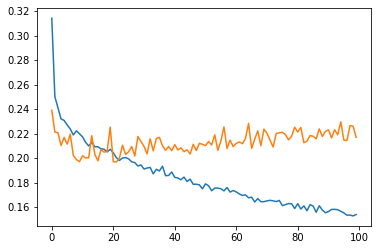

In [60]:
fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(testloss)
print(min(testloss))
plt.show()

In [32]:
test_loss  = test(test_loader, model, loss_func)
print("TEST LOSS: {}".format(test_loss))

def evaluate(data, model):
    preds, labels = [], []
    with torch.no_grad():
        for x, y in data:
            labels.append(y.item())
            preds.append(model(x[np.newaxis]).argmax().item())
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

evaluate(test_dataset, model)

TEST LOSS: 0.3549375402692117
CLASSIFICATION ACCURACY: 0.000%


0.0

## Bayesopt

In [15]:
def get_datasets(batch_size=16):
    
    # Get dataset
    test_start = int(df.shape[0]*0.8)
    valid_start = int(df.shape[0]*0.64)
    df_train = benchmark_data.loc[:valid_start].copy()
    df_valid = benchmark_data.loc[valid_start:test_start].copy()
    df_test  = benchmark_data[test_start:].copy()
    
    # Standardize features 
    for c in df_train.columns:
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_valid[c] = (df_valid[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
        
    df_train[target] = df.loc[:test_start][target]
    df_valid[target] = df.loc[valid_start:test_start][target]
    df_test[target] = df.loc[test_start:][target]
    
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features)
    valid_dataset = NFLClassificationDataset(df_valid, target=target, features=features)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features)
    
    torch.manual_seed(99)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, valid_loader, test_loader

def get_model(lr, features, hidden_size, dropout, layers):
    # hyperparameters
    lr = lr
    input_size = len(features)
    hidden_size = hidden_size
    dropout = dropout
    layers = layers

    # Build model
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU()
    )
    for l in range(layers):
        model.append(nn.Linear(hidden_size, hidden_size))
        model.append(nn.Dropout(dropout))
        model.append(nn.ReLU())
    model.append(nn.Linear(hidden_size, 2))
    model.append(nn.Softmax(dim=1))

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    return model, optimizer

In [16]:
def target_function(lr=-3, epoch=1000, hidden_size=32, layers=3, dropout=0.5, batch_size=16):
    
    train_loader, valid_loader, test_loader = get_datasets(batch_size=int(batch_size))
    model, optimizer = get_model(10**lr, features, int(hidden_size), dropout, int(layers))
    loss_func = nn.CrossEntropyLoss()
    
    # Run lstm 
    trainloss = []
    valloss = []
    for i in tqdm(range(int(epoch))):
        train_loss, model = train(train_loader, model, loss_func, optimizer=criterion)
        trainloss.append(train_loss)
        val_loss  = test(valid_loader, model, loss_func)
        valloss.append(val_loss)    
        #if(((i+1)%100) == 0 or (i == 0)):
        #    print("TRAIN LOSS: {0:.5f}".format(train_loss))
        #    print("TEST LOSS: {0:.5f}".format(val_loss))

    return evaluate(valid_loader, model)

In [17]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr': (-10,-1),
    'epoch': (10, 200),
    'hidden_size': (1, 256),
    'layers': (1, 7),
    'dropout': (0.0, 1.0),
    'batch_size': (1, 128),
}

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1
)

In [18]:
#optimizer.maximize(
#    init_points=2,
#    n_iter=3
#)